# Modelagem Estatística Parte 1

## Bibliotecas e Carregamento dos Dados

Nesta etapa inicial, realizamos a importação das bibliotecas necessárias, o carregamento dos dados principais e a leitura do dicionário de dados dos Microdados do Enem 2019. O objetivo é estruturar as metainformações para facilitar a identificação das variáveis exógenas e endógenas para nossos modelos. Foram aplicados tratamentos de limpeza, como a remoção de espaços em branco nos nomes das colunas (strip) e a exclusão de linhas nulas na coluna identificadora das variáveis, garantindo que tenhamos um mapeamento íntegro dos dados.

Para delimitar o escopo da análise, filtramos o dicionário apenas com as variáveis demográficas e escolares consideradas relevantes para o estudo (como faixa etária, sexo, cor/raça e tipo de escola). Esta etapa é crucial para a compreensão das categorias codificadas nos microdados, permitindo uma interpretação correta dos resultados estatísticos posteriores ao mapear códigos numéricos para suas respectivas descrições textuais.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import bs 

from sklearn.preprocessing import StandardScaler

import wandb
import xgboost as xgb
from econml.dml import CausalForestDML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

c:\Users\Gabriel\Documents\Ciência de Dados (UFC)\2025.2\Modelagem Estatística\statistical-modelling-enem\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parâmetros globais de visualização
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.autolayout"] = False
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

In [4]:
path_to_the_truth= r"../dados/microdados_enem_2019/dados_enem_processados.csv.zip"
df= pd.read_csv(path_to_the_truth, sep=",", encoding="utf-8", compression="zip")

df.columns

Index(['NU_INSCRICAO', 'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'N_PESSOAS_MESMA_RED',
       'INTERNET', 'MEDIA_CANDIDATO', 'SCORE_CONSUMO', 'SCORE_CULT_PAIS',
       'RENDA'],
      dtype='str')

In [5]:
df.head()

,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,N_PESSOAS_MESMA_RED,INTERNET,MEDIA_CANDIDATO,SCORE_CONSUMO,SCORE_CULT_PAIS,RENDA
0,190001867757,2,1,1,1,1,2,0,3,1.0,0,4.0,1.0,1.0,2,1,722.58,18,8.0,2245
1,190001692704,3,1,1,1,1,2,0,2,1.0,1,2.0,1.0,1.0,3,0,477.44,13,4.0,0
2,190001595660,2,1,1,2,1,2,0,2,1.0,2,2.0,1.0,1.0,3,1,498.76,7,11.0,499
3,190001421552,2,0,1,2,1,2,0,2,1.0,3,2.0,1.0,1.0,2,1,614.34,7,5.0,499
4,190001480443,3,0,2,3,4,2,0,2,1.0,4,2.0,1.0,1.0,4,1,422.28,11,6.0,1247


In [6]:
df.set_index("NU_INSCRICAO", inplace=True)

In [7]:
df.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'N_PESSOAS_MESMA_RED',
       'INTERNET', 'MEDIA_CANDIDATO', 'SCORE_CONSUMO', 'SCORE_CULT_PAIS',
       'RENDA'],
      dtype='str')

In [9]:
path_dic= r"../dados/microdados_enem_2019/DICIONÁRIO/Dicionário_Microdados_Enem_2019.xlsx"

dic_enem = pd.read_excel(path_dic, header=1)


dic_enem.columns = dic_enem.columns.str.strip()


dic_enem.rename(columns={dic_enem.columns[0]: 'NOME DA VARIÁVEL'}, inplace=True)


dic_enem = dic_enem.dropna(subset=['NOME DA VARIÁVEL'])
print(dic_enem['NOME DA VARIÁVEL'].head())

0         NOME DA VARIÁVEL
2    DADOS DO PARTICIPANTE
3             NU_INSCRICAO
4                   NU_ANO
5          TP_FAIXA_ETARIA
Name: NOME DA VARIÁVEL, dtype: str


In [10]:
colunas_descricao =['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'TP_ENSINO', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
       'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC']
descricoes = dic_enem[dic_enem['NOME DA VARIÁVEL'].isin(colunas_descricao)]

descricoes.columns = descricoes.columns.str.strip()


print("-" * 30)
print("DICIONÁRIO DE VARIÁVEIS SELECIONADAS")
print("-" * 30 + "\n")


for index, row in descricoes.iterrows():
    var_nome = row['NOME DA VARIÁVEL']
    var_desc = row['Descrição'] if 'Descrição' in descricoes.columns else row.iloc[1]
    print(f" {var_nome}:")
    print(f"{var_desc}\n")

------------------------------
DICIONÁRIO DE VARIÁVEIS SELECIONADAS
------------------------------

 TP_FAIXA_ETARIA:
Faixa etária2

 TP_SEXO:
Sexo

 TP_ESTADO_CIVIL:
Estado Civil

 TP_COR_RACA:
Cor/raça

 TP_NACIONALIDADE:
Nacionalidade

 TP_ST_CONCLUSAO:
Situação de conclusão do Ensino Médio

 TP_ANO_CONCLUIU:
Ano de Conclusão do Ensino Médio

 TP_ESCOLA:
Tipo de escola do Ensino Médio

 TP_ENSINO:
Tipo de instituição que concluiu ou concluirá o Ensino Médio 

 SG_UF_ESC:
Sigla da Unidade da Federação da escola

 TP_DEPENDENCIA_ADM_ESC:
Dependência administrativa (Escola)

 TP_LOCALIZACAO_ESC:
Localização (Escola)

 TP_SIT_FUNC_ESC:
Situação de funcionamento (Escola)



## Normalização dos Dados

Para viabilizar a comparação direta entre os coeficientes da regressão, aplicamos a padronização (StandardScaler) nas variáveis de renda, capital cultural e consumo, além da variável dependente (média do candidato). Ao transformar essas variáveis para que possuam média 0 e desvio padrão 1, garantimos que a magnitude dos coeficientes reflita a importância relativa de cada preditor no modelo, independentemente de suas escalas originais.

In [11]:
#vamos normalizar as colunas de renda, riqueza e capital cultural, para podermos comparar os coeficientes depois
scaler = StandardScaler()
df_copy= df.copy()
df_copy[['RENDA', 'SCORE_CULT_PAIS', 'SCORE_CONSUMO']] = scaler.fit_transform(df_copy[['RENDA',  'SCORE_CULT_PAIS', 'SCORE_CONSUMO']])


In [12]:
df_copy[['RENDA','SCORE_CULT_PAIS', 'SCORE_CONSUMO', 'MEDIA_CANDIDATO']].head()

,RENDA,SCORE_CULT_PAIS,SCORE_CONSUMO,MEDIA_CANDIDATO
NU_INSCRICAO,,,,
190001867757,-0.125709,0.510894,0.297759,722.58
190001692704,-0.700894,-0.450002,-0.245081,477.44
190001595660,-0.573047,1.231566,-0.896489,498.76
190001421552,-0.573047,-0.209778,-0.896489,614.34
190001480443,-0.381404,0.030446,-0.462217,422.28


In [13]:
df_copy['MEDIA_CANDIDATO']=scaler.fit_transform(df_copy[['MEDIA_CANDIDATO']])

In [14]:
df_copy['MEDIA_CANDIDATO'].head()

NU_INSCRICAO
190001867757    2.383854
190001692704   -0.646687
190001595660   -0.383118
190001421552    1.045738
190001480443   -1.328601
Name: MEDIA_CANDIDATO, dtype: float64

## MODELO 1: Regressão Linear Múltipla (OLS)

Ajustamos um modelo de Regressão Linear Múltipla (OLS) utilizando uma amostra de 10.000 observações. Utilizamos B-Splines (bs) para a faixa etária, permitindo capturar relações não lineares, e tratamos variáveis categóricas como cor/raça e tipo de escola como fatores.

In [15]:
sample= df_copy.sample(n=10000, random_state=69)

In [16]:
#vamos ver quanto fatores socieconômicos influenciam na nota do ENEM
modelo = smf.ols(formula='MEDIA_CANDIDATO ~ SCORE_CONSUMO +RENDA + SCORE_CULT_PAIS + bs(TP_FAIXA_ETARIA, df=5)+C(TP_COR_RACA)+C(INTERNET)+C(TP_ESCOLA)', data=sample).fit()
display(modelo.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MEDIA_CANDIDATO   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     339.0
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:21:04   Log-Likelihood:                -12004.
No. Observations:               10000   AIC:                         2.404e+04
Df Residuals:                    9984   BIC:                         2.415e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.1705      0.079     -2.154      0.031      -0.326      -0.015
C(TP_COR_RACA)[T.1]              0.1097      0.055      1.984      0.047       0.001       0.218
C(TP_COR_RACA)[T.2]             -0.0536      0.059     -0.910      0.363      -0.169       0.062
C(TP_COR_RACA)[T.3]             -0.0352      0.055     -0.641      0.522      -0.143       0.072
C(TP_COR_RACA)[T.4]              0.0005      0.078      0.006      0.995      -0.153       0.153
C(TP_COR_RACA)[T.5]             -0.2800      0.115     -2.439      0.015      -0.505      -0.055
C(INTERNET)[T.1]                 0.1864      0.022      8.431      0.000       0.143       0.230
C(TP_ESCOLA)[T.3]                0.5754      0.029     20.182      0.000       0.520       0.631
SCORE_CONSUMO                    0.1207      0.013      9.373      0.000       0.095       0.146
RENDA                            0.1139      0.012      9.432      0.000       0.090       0.138
SCORE_CULT_PAIS                  0.1620      0.010     16.085      0.000       0.142       0.182
bs(TP_FAIXA_ETARIA, df=5)[0]    -0.3866      0.126     -3.064      0.002      -0.634      -0.139
bs(TP_FAIXA_ETARIA, df=5)[1]     0.1777      0.070      2.523      0.012       0.040       0.316
bs(TP_FAIXA_ETARIA, df=5)[2]    -1.2305      0.176     -7.006      0.000      -1.575      -0.886
bs(TP_FAIXA_ETARIA, df=5)[3]    -0.2497      0.416     -0.600      0.548      -1.065       0.566
bs(TP_FAIXA_ETARIA, df=5)[4]    -0.8358      0.425     -1.967      0.049      -1.669      -0.003
==============================================================================
Omnibus:                       70.531   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.768
Skew:                           0.204   Prob(JB):                     2.60e-16
Kurtosis:                       2.927   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Análise do Resultado

- **Ajuste do Modelo**: O R² de 0,337 indica que o modelo explica aproximadamente 33,7% da variabilidade da nota média dos candidatos.
- **Significância**: Variáveis como SCORE_CULT_PAIS (coef: 0,1620), RENDA (0,1139) e TP_ESCOLA (0,5754 para o nível 3) apresentaram forte significância estatística (p < 0,05).
- **Impacto Socioeconômico**: O capital cultural dos pais e o acesso à internet mostraram-se preditores positivos relevantes. 

Notavelmente, o tipo de escola (privada) apresenta o maior coeficiente positivo, sugerindo uma disparidade acentuada no desempenho acadêmico baseada na natureza da instituição de ensino.

In [ ]:
#para uso futuro
#formula_modelo= 'MEDIA_CANDIDATO ~ SCORE_CONSUMO +RENDA + SCORE_CULT_PAIS + bs(TP_FAIXA_ETARIA, df=5)+C(TP_COR_RACA)+C(INTERNET)+C(TP_ESCOLA)'

### Diagnóstico de Multicolinearidade (VIF)

Calculamos o Fator de Inflação da Variância (VIF) para verificar se as variáveis independentes estão excessivamente correlacionadas entre si. O Intercepto e algumas categorias de TP_COR_RACA apresentaram VIFs elevados (acima de 10). Isso indica que existe uma redundância de informação ou uma forte correlação entre os preditores, o que pode instabilizar os coeficientes e inflar os erros padrão. Por conta disso, vamos remover o intercepto e ver como o modelo fica após isso. 

In [17]:
exog = modelo.model.exog
exog_names = modelo.model.exog_names
for i, col in enumerate(exog_names):
    print(col, variance_inflation_factor(exog, i))

Intercept 96.84702225354427
C(TP_COR_RACA)[T.1] 11.288541845483502
C(TP_COR_RACA)[T.2] 5.1888184209869666
C(TP_COR_RACA)[T.3] 11.515898697549188
C(TP_COR_RACA)[T.4] 1.854408481155857
C(TP_COR_RACA)[T.5] 1.2751346964287158
C(INTERNET)[T.1] 1.2447449662376626
C(TP_ESCOLA)[T.3] 1.5038806970090697
SCORE_CONSUMO 2.5703553232917926
RENDA 2.304120434247441
SCORE_CULT_PAIS 1.5797091113721722
bs(TP_FAIXA_ETARIA, df=5)[0] 3.8340742480386774
bs(TP_FAIXA_ETARIA, df=5)[1] 1.5157598712776337
bs(TP_FAIXA_ETARIA, df=5)[2] 5.596652579075396
bs(TP_FAIXA_ETARIA, df=5)[3] 3.9835220403438782
bs(TP_FAIXA_ETARIA, df=5)[4] 2.248184332611097


### Modelo Sem Intercepto e Reavaliação

In [18]:
modelo_1_barra=smf.ols(formula='MEDIA_CANDIDATO ~ SCORE_CONSUMO +RENDA + SCORE_CULT_PAIS + TP_SEXO+TP_FAIXA_ETARIA+TP_COR_RACA+INTERNET+TP_ESCOLA-1', data=sample).fit()
display(modelo_1_barra.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        MEDIA_CANDIDATO   R-squared (uncentered):                   0.321
Model:                            OLS   Adj. R-squared (uncentered):              0.321
Method:                 Least Squares   F-statistic:                              591.5
Date:                Tue, 27 Jan 2026   Prob (F-statistic):                        0.00
Time:                        11:21:10   Log-Likelihood:                         -12123.
No. Observations:               10000   AIC:                                  2.426e+04
Df Residuals:                    9992   BIC:                                  2.432e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
SCORE_CONSUMO       0.1543      0.013     12.041      0.000       0.129       0.179
RENDA               0.1441      0.012     12.009      0.000       0.121       0.168
SCORE_CULT_PAIS     0.1808      0.010     17.941      0.000       0.161       0.201
TP_SEXO            -0.0863      0.016     -5.252      0.000      -0.119      -0.054
TP_FAIXA_ETARIA    -0.1237      0.007    -17.615      0.000      -0.137      -0.110
TP_COR_RACA        -0.0898      0.008    -11.265      0.000      -0.105      -0.074
INTERNET            0.0976      0.021      4.592      0.000       0.056       0.139
TP_ESCOLA           0.2373      0.014     16.935      0.000       0.210       0.265
==============================================================================
Omnibus:                       61.315   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.476
Skew:                           0.182   Prob(JB):                     4.47e-14
Kurtosis:                       2.879   Cond. No.                         12.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Análise Comparativa

1. Houve uma redução drástica no número de condição (comparado ao modelo anterior), indicando que este modelo é numericamente mais estável e sofre menos com multicolinearidade.

2. Mesmo sem o intercepto, os sinais e a significância das variáveis principais se mantiveram. A variável TP_FAIXA_ETARIA agora apresenta um coeficiente negativo (-0.1237), confirmando que, em média, o aumento da idade (que pode indicar maior tempo fora da escola) está associado a uma queda na nota.

3. Embora o R² não seja diretamente comparável ao modelo com constante, o ajuste permanece robusto, confirmando que os fatores socioeconômicos e o capital cultural são fundamentais na explicação do desempenho acadêmico no Enem.

### Visualização dos Resultados

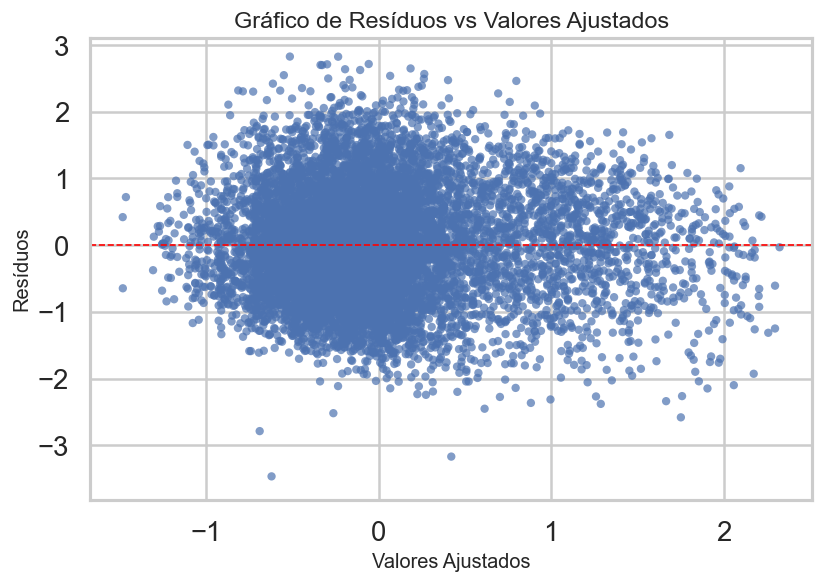

In [19]:
residuos = modelo.resid
ajustados = modelo.fittedvalues

fig, ax = plt.subplots(figsize=(7, 5))

sns.scatterplot(x=ajustados, y=residuos, s=25, alpha=0.7, edgecolor="none", ax=ax)

# Linha horizontal em zero
ax.axhline(0, color="red", linestyle="--", linewidth=1)

ax.set_title("Gráfico de Resíduos vs Valores Ajustados")
ax.set_xlabel("Valores Ajustados")
ax.set_ylabel("Resíduos")

# Opcional: ajustar limites para dar um pouco de margem visual
ymin, ymax = residuos.min(), residuos.max()
ax.set_ylim(ymin - 0.1 * abs(ymin), ymax + 0.1 * abs(ymax))

plt.tight_layout()
plt.show()

#### Análise do Gráfico de Resíduso vs Valores Ajustados

A ausência de um padrão claro (como uma parábola ou um formato em "U") sugere que a relação entre as variáveis independentes e a nota média do candidato é predominantemente linear, indicando que a especificação do modelo está adequada.Além disso, ao observarmos a dispersão vertical dos pontos ao longo do eixo horizontal (Valores Ajustados), notamos uma distribuição relativamente simétrica.

Embora existam outliers, a densidade da massa de dados sugere que eles não estão deslocando a linha de tendência de forma significativa.

Portanto, A distribuição "em nuvem" sem padrões sistemáticos é positivo, pois nos indica que o erro do modelo é aleatório (ruído branco) e que a maior parte da informação útil das variáveis explicativas (Renda, Escola, Cor/Raça, etc.) já foi capturada pelo modelo, restando nos resíduos apenas o que não pode ser previsto pelas variáveis selecionadas.

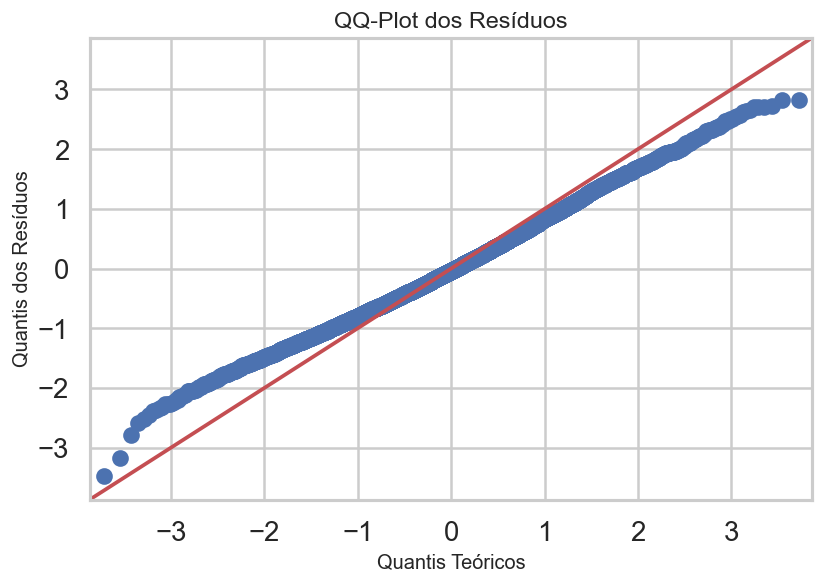

In [20]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

sm.qqplot(residuos, line="45", ax=ax)

ax.set_title("QQ-Plot dos Resíduos")
ax.set_xlabel("Quantis Teóricos")
ax.set_ylabel("Quantis dos Resíduos")

plt.tight_layout()
plt.show()

#### Análise do Gráficos QQ-Plot dos Resíduos

O gráfico revela desvios importantes nas caudas (heterocedasticidade). Tanto da esquerda inferior quanto na direita superior, isso sugere que a distribuição dos resíduos é ligeiramente platicúrtica nessa extremidade, ou seja, as notas muito altas não são tão extremas quanto a teoria normal preveria.

Embora o gráfico mostre que os resíduos não são perfeitamente normais, o comportamento na região central é bastante robusto.

Portanto, o modelo é confiável para inferência, mas a fuga da normalidade nas caudas sugere que existem fatores não capturados (variáveis omitidas ou idiossincrasias dos candidatos) que explicam os desempenhos excepcionalmente baixos.

## Modelo 2: MULTINÍVEL

In [ ]:
#subset=['SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO']

Realizamos um cálculo exploratório do ICC (Coeficiente de Correlação Intraclasse) de forma manual a fim de testar o ICC do agrupamento


In [16]:
media_grupais= df_copy.groupby("SG_UF_ESC")["MEDIA_CANDIDATO"].mean()
var_between = media_grupais.var()

var_within = df_copy.groupby("SG_UF_ESC")["MEDIA_CANDIDATO"].var().mean()

icc_naive = var_between / (var_between + var_within)
icc_naive


0.04891343932130746

O ICC de aproximadamente 4,9% indica que cerca de 5% da variação total das notas do ENEM pode ser explicada apenas pela diferença entre as Unidades da Federação (UF). Embora pareça um valor baixo, em ciências sociais de larga escala, isso justifica o uso de modelos multinível para controlar a dependência dos dados dentro de cada estado.

### Preparação de Variáveis Agregadas e Fórmula

Nesta etapa, ensinamos contexto ao modelo multinível criando variáveis (médias por UF) para Renda, Escolaridade, Internet e Consumo.

In [ ]:
df_copy["RENDA_UF"] = df_copy.groupby("SG_UF_ESC")["RENDA"].transform("mean")
df_copy["ESCOLARIDADE_C"] = df_copy.groupby("SG_UF_ESC")["TP_ESCOLA"].transform("mean")
df_copy["INTERNET_UF"] = df_copy.groupby("SG_UF_ESC")["INTERNET"].transform("mean")
df_copy["SCORE_CULT_PAIS_UF"] = df_copy.groupby("SG_UF_ESC")["SCORE_CULT_PAIS"].transform("mean")
df_copy["SCORE_CONSUMO_UF"] = df_copy.groupby("SG_UF_ESC")["SCORE_CONSUMO"].transform("mean")

Definimos a nova_formula que será utilizada no modelo de efeitos mistos, mantendo os principais preditores socioeconômicos e demográficos (Renda, Capital Cultural, Cor/Raça, Internet e Tipo de Escola).

In [ ]:
nova_formula = (
    'MEDIA_CANDIDATO ~  RENDA + SCORE_CULT_PAIS+'
    'C(TP_COR_RACA) + C(INTERNET)  + C(TP_ESCOLA)'
)

### Modelo de Efeitos Mistos (Agrupamento por UF)

Ajustamos um modelo MixedLM (Multilevel) utilizando a Unidade da Federação (SG_UF_ESC) como nível de agrupamento (intercepto aleatório).

In [58]:
modelo_2=smf.mixedlm(formula=nova_formula, data=df_copy, groups=df_copy['SG_UF_ESC']).fit()
display(modelo_2.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM Dependent Variable: MEDIA_CANDIDATO
No. Observations:   880332  Method:             REML           
No. Groups:         27      Scale:              0.6635         
Min. group size:    1589    Log-Likelihood:     -1068679.1112  
Max. group size:    168445  Converged:          Yes            
Mean group size:    32604.9                                    
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           -0.259    0.023 -11.039 0.000 -0.305 -0.213
C(TP_COR_RACA)[T.1]  0.110    0.006  17.315 0.000  0.097  0.122
C(TP_COR_RACA)[T.2] -0.062    0.007  -9.210 0.000 -0.075 -0.049
C(TP_COR_RACA)[T.3] -0.029    0.006  -4.610 0.000 -0.041 -0.017
C(TP_COR_RACA)[T.4]  0.017    0.008   2.062 0.039  0.001  0.034
C(TP_COR_RACA)[T.5] -0.221    0.013 -16.871 0.000 -0.247 -0.195
C(INTERNET)[T.1]     0.162    0.002  66.044 0.000  0.157  0.167
C(TP_ESCOLA)[T.3]    0.569    0.003 182.753 0.000  0.563  0.576
RENDA                0.119    0.001  90.832 0.000  0.117  0.122
SCORE_CULT_PAIS      0.207    0.001 188.832 0.000  0.205  0.209
SCORE_CONSUMO        0.121    0.001  83.837 0.000  0.119  0.124
Group Var            0.014    0.005                            
===============================================================

"""

### Análise dos Resultados

Todos os coeficientes principais são altamente significativos (P < 0.001).

O SCORE_CULT_PAIS (0.207) continua sendo um dos preditores mais fortes, superando o efeito direto da RENDA (0.119). O efeito de estudar em escola privada (TP_ESCOLA[T.3]) é muito expressivo (0.569), mostrando que a estrutura escolar é um divisor de águas no desempenho.

Por fim, chegamos a um group_var de 0.014, esta é a variância do intercepto aleatório, confirmando que, mesmo após controlar por renda e escola, o estado de origem ainda causa um deslocamento na nota base.

### ICC do Modelo Ajustado

In [29]:
def icc_calc(group_var, sum_var):
    total_var = group_var + sum_var
    return group_var / total_var

In [30]:
icc_mixed = icc_calc(0.014, 0.660)

icc_mixed

0.020771513353115726

O valor caiu para 2,07%. Isso significa que as variáveis explicativas que adicionamos (Renda, Escola, etc.) conseguiram explicar mais da metade da variação que antes era atribuída apenas ao "efeito estado". O que resta é o efeito puro da UF que não depende das características socioeconômicas medidas.

### Mapeamento e Codificação de Grupos

In [33]:
dic_reverso={'PR': 0,
 'RS': 1,
 'SP': 2,
 'BA': 3,
 'PB': 4,
 'AM': 5,
 'DF': 6,
 'PI': 7,
 'PA': 8,
 'MG': 9,
 'CE': 10,
 'RJ': 11,
 'RN': 12,
 'MS': 13,
 'MT': 14,
 'TO': 15,
 'AL': 16,
 'GO': 17,
 'AP': 18,
 'PE': 19,
 'SC': 20,
 'MA': 21,
 'ES': 22,
 'RO': 23,
 'AC': 24,
 'SE': 25,
 'RR': 26}

dic_reverso={v:k for k, v in dic_reverso.items()}


In [34]:
df_copy['SG_UF_ESC_CODE'] = df_copy['SG_UF_ESC'].map(dic_reverso)

### Extração de Efeitos Aleatórios (Ranking de Valor Agregado)

O objetivo aqui é encontrar o df_ranking resultante, o qual, na prática, é um ranking de eficiência educacional dos estados, mostrando quais UFs entregam notas acima do esperado dada a realidade socioeconômica de seus alunos.

In [ ]:
re_dict = modelo_2.random_effects

df_ranking = pd.DataFrame.from_dict(re_dict, orient='index')

df_ranking.columns = ['Valor_Agregado']

df_ranking.index = df_ranking.index.map(dic_reverso)

df_ranking = df_ranking.sort_values(by='Valor_Agregado', ascending=True)

### Visualização dos Resultados

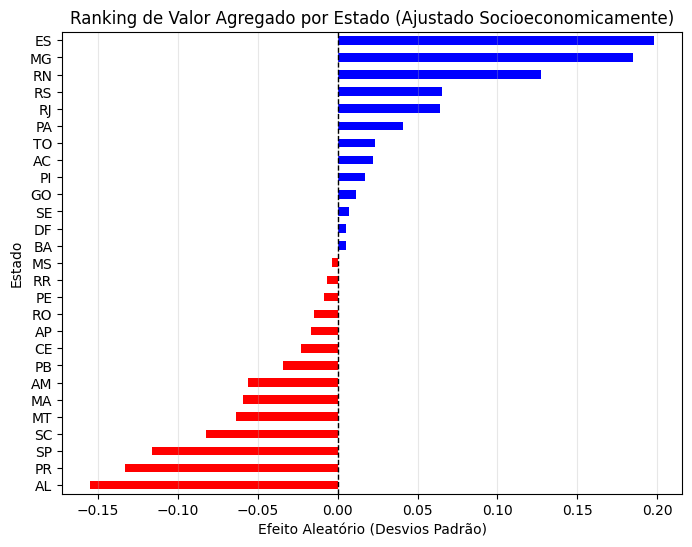

In [39]:
plt.figure(figsize=(8, 6))

cores = ['blue' if x > 0 else 'red' for x in df_ranking['Valor_Agregado']]

df_ranking['Valor_Agregado'].plot(kind='barh', color=cores)

plt.axvline(0, color='black', linestyle='--', linewidth=1) # linha da média nacional
plt.title('Ranking de Valor Agregado por Estado (Ajustado Socioeconomicamente)')
plt.xlabel('Efeito Aleatório (Desvios Padrão)')
plt.ylabel('Estado')
plt.grid(axis='x', alpha=0.3)
plt.show()

Conclusão: Devido a pequena escala, os efeitos aleatórios, ainda quando controlados, não representam muito da nota de um participante a ponto de ser uma métrica que mostre grande interesse. 

### Modelo Multinível com Grupos por Consumo

Alteramos a estrutura do modelo para agrupar os dados pelo SCORE_CONSUMO em vez da UF.

In [25]:
modelo_3=smf.mixedlm(formula=nova_formula, data=df_copy, groups=df_copy['SCORE_CONSUMO']).fit()

display(modelo_3.summary())

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM Dependent Variable: MEDIA_CANDIDATO
No. Observations:   880332  Method:             REML           
No. Groups:         76      Scale:              0.6708         
Min. group size:    1       Log-Likelihood:     -1073609.5499  
Max. group size:    95158   Converged:          Yes            
Mean group size:    11583.3                                    
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           -0.163    0.019  -8.469 0.000 -0.201 -0.125
C(TP_COR_RACA)[T.1]  0.102    0.006  16.123 0.000  0.090  0.115
C(TP_COR_RACA)[T.2] -0.051    0.007  -7.632 0.000 -0.064 -0.038
C(TP_COR_RACA)[T.3] -0.028    0.006  -4.417 0.000 -0.040 -0.016
C(TP_COR_RACA)[T.4]  0.015    0.009   1.744 0.081 -0.002  0.032
C(TP_COR_RACA)[T.5] -0.232    0.013 -17.604 0.000 -0.258 -0.206
C(INTERNET)[T.1]     0.150    0.003  57.885 0.000  0.145  0.155
C(TP_ESCOLA)[T.3]    0.594    0.003 191.891 0.000  0.588  0.600
RENDA                0.148    0.001 106.318 0.000  0.146  0.151
SCORE_CULT_PAIS      0.187    0.001 169.690 0.000  0.185  0.189
Group Var            0.021    0.005                            
===============================================================

"""

### Análise dos Resultados

O modelo convergiu com 76 grupos. O objetivo aqui foi entender se o nível de consumo da família cria "nichos" de desempenho. A RENDA (0.148) ganhou mais peso neste modelo em comparação ao anterior, e a variância de grupo (Group Var: 0.021) sugere que o nível de consumo é um agrupador de desempenho ligeiramente mais forte que a geografia estadual.

### ICC do Modelo por Consumo

In [32]:
icc_mixed = icc_calc(0.021, 0.670)

icc_mixed

0.030390738060781474

O valor de 3,04% indica que o agrupamento por padrões de consumo explica uma parcela maior da variância residual do que o agrupamento por estados. Isso sugere que a estratificação social por consumo é um fator de diferenciação educacional ligeiramente mais persistente do que as fronteiras geográficas estaduais.